# Clustering Notebook

In this notebook we will explore clustering methods on the survey answer data

In [4]:
import pandas as pd
data = pd.read_csv('../data/cleaned_data_v2.csv')

Filter the data

In [5]:
# Load scoring table
scoring = pd.read_excel('../scoring/scoring.xlsx')
survey_answer_cols = scoring['id'].tolist()
time_cols = [(col+'_E') for col in survey_answer_cols]
score_cols = ['O score', 'C score', 'E score', 'A score', 'N score']

survey_data = data[survey_answer_cols]
time_data = data[time_cols]
score_data = data[score_cols]


Scale the data

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
survey_data = scaler.fit_transform(survey_data)  
time_data = scaler.fit_transform(time_data)  
score_data = scaler.fit_transform(score_data)  


K-means

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Define a range of n_clusters to test
cluster_range = range(2, 21)  # Try cluster numbers from 2 to 20

# Initialize lists to store the scores for each n_clusters
dbi_scores = []
ch_scores = []

# Loop through the range of n_clusters
for n_clusters in cluster_range:
    mb_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
    mb_clusters = mb_kmeans.fit_predict(score_data)
    
    # Calculate Davies-Bouldin and Calinski-Harabasz scores
    dbi = davies_bouldin_score(score_data, mb_clusters)
    ch = calinski_harabasz_score(score_data, mb_clusters)
    
    # Append the scores to the respective lists
    dbi_scores.append(dbi)
    ch_scores.append(ch)



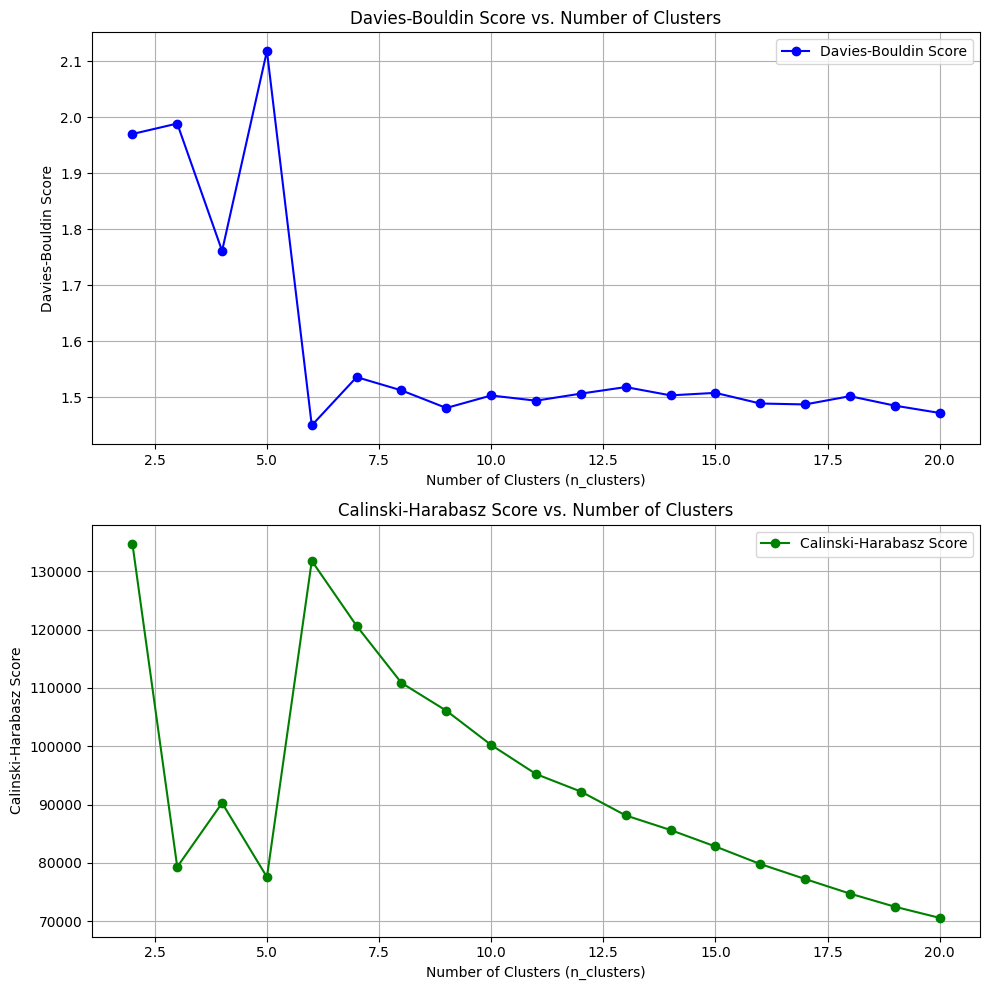

In [14]:
# Create 2x1 grid of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot Davies-Bouldin Score on the first subplot (ax1)
ax1.plot(cluster_range, dbi_scores, label='Davies-Bouldin Score', color='blue', marker='o')
ax1.set_xlabel('Number of Clusters (n_clusters)')
ax1.set_ylabel('Davies-Bouldin Score')
ax1.set_title('Davies-Bouldin Score vs. Number of Clusters')
ax1.grid(True)
ax1.legend()

# Plot Calinski-Harabasz Score on the second subplot (ax2)
ax2.plot(cluster_range, ch_scores, label='Calinski-Harabasz Score', color='green', marker='o')
ax2.set_xlabel('Number of Clusters (n_clusters)')
ax2.set_ylabel('Calinski-Harabasz Score')
ax2.set_title('Calinski-Harabasz Score vs. Number of Clusters')
ax2.grid(True)
ax2.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()

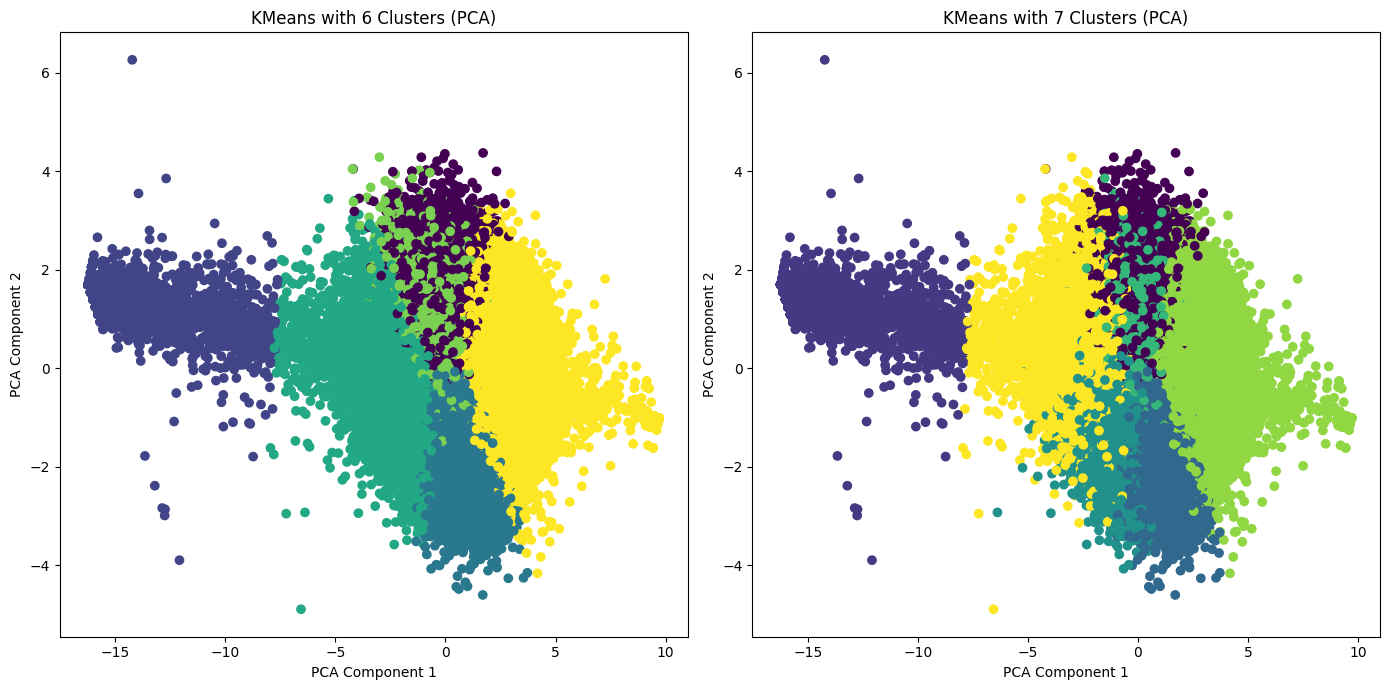

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Fit KMeans with 6 and 7 clusters
kmeans_6 = MiniBatchKMeans(n_clusters=6, random_state=42, batch_size=1000)
kmeans_7 = MiniBatchKMeans(n_clusters=7, random_state=42, batch_size=1000)

# Assign clusters
clusters_6 = kmeans_6.fit_predict(score_data)
clusters_7 = kmeans_7.fit_predict(score_data)

# Use PCA for dimensionality reduction (2D)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(score_data)

# Create subplots to show the visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot for 6 clusters
axes[0].scatter(data_pca[:, 0], data_pca[:, 1], c=clusters_6, cmap='viridis', marker='o')
axes[0].set_title('KMeans with 6 Clusters (PCA)')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')

# Plot for 7 clusters
axes[1].scatter(data_pca[:, 0], data_pca[:, 1], c=clusters_7, cmap='viridis', marker='o')
axes[1].set_title('KMeans with 7 Clusters (PCA)')
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


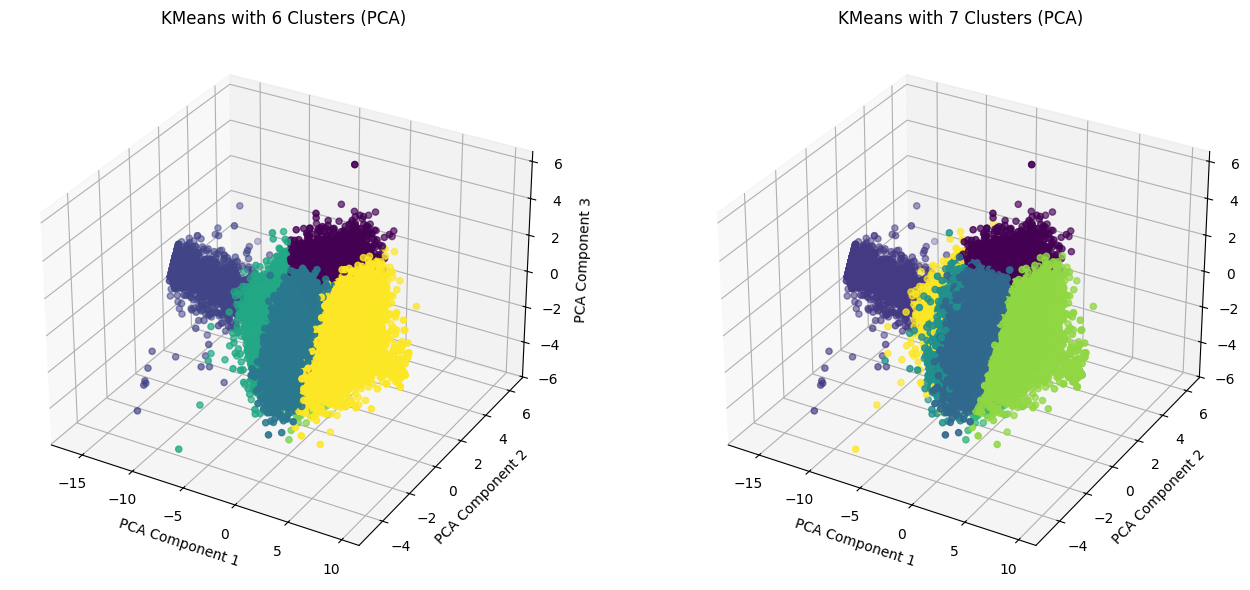

In [16]:
# Use PCA for 3D reduction
pca = PCA(n_components=3)
data_pca = pca.fit_transform(score_data)

# Create subplots for 3D visualization
fig = plt.figure(figsize=(14, 6))

# 3D Plot for 6 clusters
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=clusters_6, cmap='viridis', marker='o')
ax1.set_title('KMeans with 6 Clusters (PCA)')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')

# 3D Plot for 7 clusters
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=clusters_7, cmap='viridis', marker='o')
ax2.set_title('KMeans with 7 Clusters (PCA)')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.set_zlabel('PCA Component 3')

# Adjust layout and show
plt.tight_layout()
plt.show()

In [21]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from tqdm import tqdm

# Subset the data (let's say we use 10% of the original data for faster testing)
subset_size = int(0.1 * len(score_data))  # 10% of the data
subset_data = score_data[np.random.choice(score_data.shape[0], subset_size, replace=False)]

# Define the clustering algorithms and their number of clusters
clustering_methods = {
    "Agglomerative Clustering": AgglomerativeClustering(n_clusters=6, linkage="single"),
    "Gaussian Mixture Model (GMM)": GaussianMixture(n_components=6, random_state=42),
    "DBSCAN": DBSCAN(eps=1.5, min_samples=10),
   
    #"Mean Shift": MeanShift()
}

# Initialize dictionaries to store the scores
db_scores = {}
ch_scores = {}

# Function to calculate scores for each model
def calculate_scores(method_name, model, data):
    if method_name == "DBSCAN":  # DBSCAN doesn't require a fixed number of clusters
        clusters = model.fit_predict(data)
    else:
        clusters = model.fit_predict(data)

    # Calculate DB and CH scores
    db_score = davies_bouldin_score(data, clusters)
    ch_score = calinski_harabasz_score(data, clusters)

    return (method_name, db_score, ch_score)

# Run the clustering methods sequentially and track progress with tqdm
for method_name, model in tqdm(clustering_methods.items(), desc="Clustering Methods", unit="method"):
    method_name, db_score, ch_score = calculate_scores(method_name, model, score_data)
    
    # Store the results in the dictionaries
    db_scores[method_name] = db_score
    ch_scores[method_name] = ch_score

# Print the DB and CH scores for each method
print("Davies-Bouldin Scores:")
for method, score in db_scores.items():
    print(f"{method}: {score:.4f}")

print("\nCalinski-Harabasz Scores:")
for method, score in ch_scores.items():
    print(f"{method}: {score:.4f}")

Clustering Methods:  67%|██████▋   | 2/3 [1:08:36<28:16, 1696.91s/method]  

: 

: 

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans

# Fit KMeans with 6 and 7 clusters
kmeans_6 = MiniBatchKMeans(n_clusters=6, random_state=42, batch_size=1000)
kmeans_7 = MiniBatchKMeans(n_clusters=7, random_state=42, batch_size=1000)

# Assign clusters
clusters_6 = kmeans_6.fit_predict(score_data)
clusters_7 = kmeans_7.fit_predict(score_data)


In [7]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Ensure score_data is a NumPy array
score_data = np.array(score_data)  

# Sample 10% of the data using NumPy
subset_size = int(0.1 * len(score_data))  # 10% of rows
subset = score_data[np.random.choice(score_data.shape[0], subset_size, replace=False)]

# Apply GMM with a chosen number of clusters (e.g., 3)
gmm = GaussianMixture(n_components=6, random_state=42, n_init=1)
subset_clusters = gmm.fit_predict(subset)

# Compute evaluation metrics
ch_score = calinski_harabasz_score(subset, subset_clusters)
db_score = davies_bouldin_score(subset, subset_clusters)

print(f"Calinski-Harabasz Score: {ch_score}")
print(f"Davies-Bouldin Score: {db_score}")


Calinski-Harabasz Score: 7816.096464169378
Davies-Bouldin Score: 1.9938342456494536


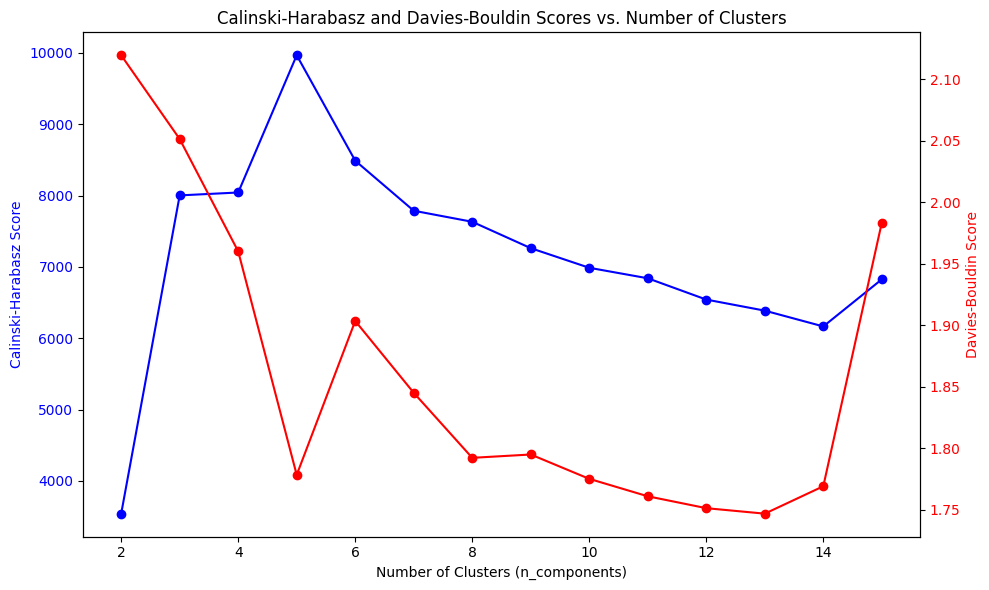

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Sample 10% of the data using NumPy
subset_size = int(0.1 * len(score_data))  # 10% of rows
subset = score_data[np.random.choice(score_data.shape[0], subset_size, replace=False)]

# Define range of cluster sizes
n_clusters_range = range(2, 16)

# Lists to store scores for each n_components value
ch_scores = []
db_scores = []

# Loop over different cluster numbers
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42, n_init=1)  # 10 initializations
    clusters = gmm.fit_predict(subset)
    
    # Compute evaluation metrics
    ch_score = calinski_harabasz_score(subset, clusters)
    db_score = davies_bouldin_score(subset, clusters)
    
    # Append the scores to the lists
    ch_scores.append(ch_score)
    db_scores.append(db_score)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Calinski-Harabasz score (first y-axis)
ax1.plot(n_clusters_range, ch_scores, label='Calinski-Harabasz Score', marker='o', color='b')
ax1.set_xlabel('Number of Clusters (n_components)')
ax1.set_ylabel('Calinski-Harabasz Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create the second y-axis
ax2 = ax1.twinx()

# Plot Davies-Bouldin score (second y-axis)
ax2.plot(n_clusters_range, db_scores, label='Davies-Bouldin Score', marker='o', color='r')
ax2.set_ylabel('Davies-Bouldin Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and layout
plt.title('Calinski-Harabasz and Davies-Bouldin Scores vs. Number of Clusters')
fig.tight_layout()

# Show plot
plt.show()


In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Fit a GMM model
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(score_data)

# Get the hard cluster assignments (i.e., cluster with highest probability for each data point)
cluster_labels = gmm.predict(score_data)

# Calculate the silhouette score
silhouette_avg = silhouette_score(score_data, cluster_labels)
print(f"Silhouette Score for GMM: {silhouette_avg}")


Silhouette Score for GMM: 0.15787596307799148


## Add cluster assignments

In [7]:
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture

# Extract original (non-normalized) score data
score_data_original = data[score_cols].copy()

# Standardize score data for clustering
scaler = StandardScaler()
score_data_scaled = scaler.fit_transform(score_data_original)

# Apply MiniBatch KMeans (6 clusters)
kmeans = MiniBatchKMeans(n_clusters=6, random_state=42, batch_size=100)
data['KMeans_Cluster'] = kmeans.fit_predict(score_data_scaled)

# Apply Gaussian Mixture Model (5 clusters)
gmm = GaussianMixture(n_components=5, random_state=42)
data['GMM_Cluster'] = gmm.fit_predict(score_data_scaled)

# Save the updated dataset with cluster assignments
data.to_csv('../data/cleaned_data_with_clusters.csv', index=False)

print("Clustering complete. Data saved as 'cleaned_data_with_clusters.csv'.")
